In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tqdm import tqdm 

In [2]:
path_main = r'.\Acute lymphoblastic leukemia\C-NMC_Leukemia'
path_training = os.path.join(path_main, 'training_data')
path_testing = os.path.join(path_main, 'testing_data')
path_validation = os.path.join(path_main, 'validation_data')

In [3]:
path_to_all_cells = os.path.join(path_training, 'all')
path_to_hem_cells = os.path.join(path_training, 'hem')

images_all_cells = glob(path_to_all_cells + '\\*.*')
images_hem_cells = glob(path_to_hem_cells + '\\*.*')

path_to_all_cells_validation = os.path.join(path_validation, 'all')
path_to_hem_cells_validation = os.path.join(path_validation, 'hem')

images_all_cells_validation = glob(path_to_all_cells_validation + '\\*.*')
images_hem_cells_validation = glob(path_to_hem_cells_validation + '\\*.*')

In [4]:
images_list = [x for x in images_all_cells]
images_list.extend([x for x in images_hem_cells])

dataframe = pd.DataFrame(np.concatenate([
    ['0'] * len(images_all_cells),
    ['1'] * len(images_hem_cells),
]), columns=['label'])

dataframe['image'] = [x for x in images_list]
dataframe.head()

images_list_validation = [x for x in images_all_cells_validation]
images_list_validation.extend([x for x in images_hem_cells_validation])

dataframe_validation = pd.DataFrame(np.concatenate([
    ['0'] * len(images_all_cells_validation),
    ['1'] * len(images_hem_cells_validation),
]), columns=['label'])

dataframe_validation['image'] = [x for x in images_list_validation]

In [5]:
dataframe_training = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
dataframe_training.head()

dataframe_validation = dataframe_validation.sample(frac=1, random_state=42).reset_index(drop=True)
dataframe_validation.head()

,label,image
0,1,F:\Django\Acute lymphoblastic leukemia\C-NMC_L...
1,1,F:\Django\Acute lymphoblastic leukemia\C-NMC_L...
2,1,F:\Django\Acute lymphoblastic leukemia\C-NMC_L...
3,1,F:\Django\Acute lymphoblastic leukemia\C-NMC_L...
4,1,F:\Django\Acute lymphoblastic leukemia\C-NMC_L...


In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(dataframe_training['label'])
y_validation = encoder.fit_transform(dataframe_validation['label'])

In [7]:
images = dataframe_training['image']
images_testing = dataframe_validation['image']
X_train = []
X_validation = []

for image in tqdm(images):
    image = cv2.imread(image)
    image = cv2.resize(image, (200, 200))
    image = image / 255
    X_train.append(image)
    
for image in tqdm(images_testing):
    image = cv2.imread(image)
    image = cv2.resize(image, (200, 200))
    image = image / 255
    X_validation.append(image)

100%|██████████| 1690/1690 [02:01<00:00, 13.91it/s]


In [8]:
X_train = np.array(X_train, dtype=np.float16)
X_validation = np.array(X_validation, dtype=np.float16)

In [9]:
print(f'X_train shape: {X_train.shape}')
print(f'X_validation shape: {X_validation.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_validation shape: {y_validation.shape}')

X_train shape: (5088, 200, 200, 3)
X_validation shape: (1690, 200, 200, 3)
y_train shape: (5088,)
y_validation shape: (1690,)


In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import xception
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
def modelXception():
    base = xception.Xception(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=output_layer)
    
    model.compile(optimizer=SGD(learning_rate=0.001, decay=1e-6, momentum=0.6, nesterov=True),
                     loss=BinaryCrossentropy(), 
                         metrics=['accuracy'])
    return model

In [12]:
model = modelXception()

In [16]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_validation, y_validation), verbose=1)

Epoch 1/10
318/318 [==============================] - 243s 765ms/step - loss: 0.5588 - accuracy: 0.7337 - val_loss: 0.6856 - val_accuracy: 0.5651
Epoch 2/10
318/318 [==============================] - 328s 1s/step - loss: 0.3952 - accuracy: 0.8312 - val_loss: 0.7206 - val_accuracy: 0.6219
Epoch 3/10
318/318 [==============================] - 234s 737ms/step - loss: 0.3229 - accuracy: 0.8664 - val_loss: 0.6371 - val_accuracy: 0.6704
Epoch 4/10
318/318 [==============================] - 269s 845ms/step - loss: 0.2599 - accuracy: 0.8949 - val_loss: 0.6010 - val_accuracy: 0.7225
Epoch 5/10
318/318 [==============================] - 292s 918ms/step - loss: 0.1996 - accuracy: 0.9255 - val_loss: 0.6283 - val_accuracy: 0.7148
Epoch 6/10
318/318 [==============================] - 421s 1s/step - loss: 0.1687 - accuracy: 0.9391 - val_loss: 0.6541 - val_accuracy: 0.7266
Epoch 7/10
318/318 [==============================] - 516s 2s/step - loss: 0.1264 - accuracy: 0.9546 - val_loss: 0.7205 - val_accu

In [17]:
tf.keras.models.save_model(model, 'xception.h5')

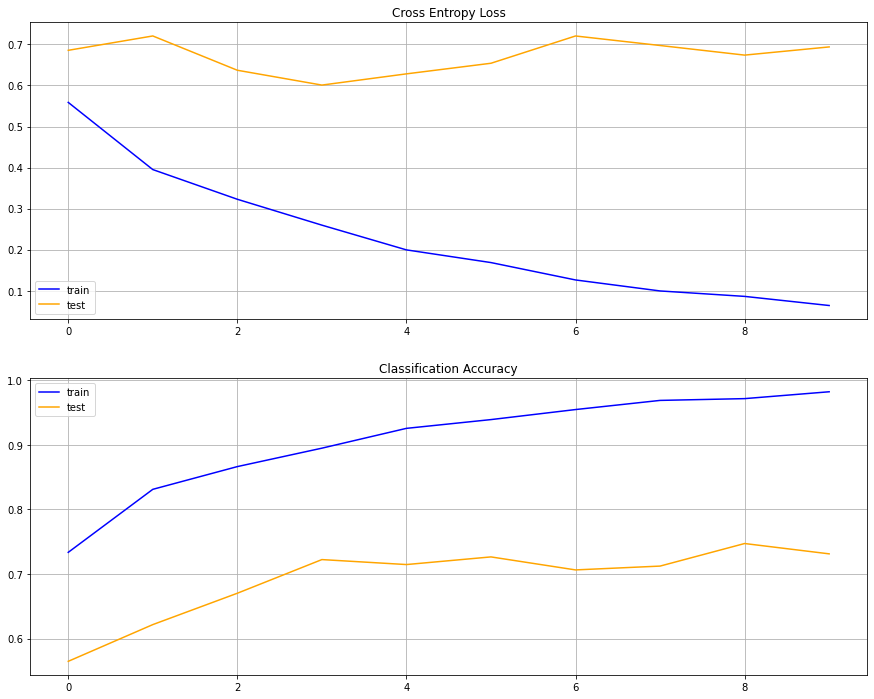

In [18]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.set_title('Cross Entropy Loss')
ax1.plot(history.history['loss'], color='blue', label='train')
ax1.plot(history.history['val_loss'], color='orange', label='test')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.set_title('Classification Accuracy')
ax2.plot(history.history['accuracy'], color='blue', label='train')
ax2.plot(history.history['val_accuracy'], color='orange', label='test')
ax2.legend()

In [19]:
dataframe_testing = pd.read_csv(path_testing + '\C-NMC_test_prelim_phase_data_labels.csv')
dataframe_testing.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [20]:
dataframe_testing = dataframe_testing.drop(columns=['Patient_ID'])
dataframe_testing.head()

,new_names,labels
0,1.bmp,1
1,2.bmp,1
2,3.bmp,1
3,4.bmp,0
4,5.bmp,1


In [33]:
path_to_testing_images = os.path.join(path_testing, 'C-NMC_test_prelim_phase_data')
images_testing = []
for image in tqdm(dataframe_testing['new_names']):
    image = glob(path_to_testing_images + '/' + image)
    image = cv2.imread(image[0])
    image = cv2.resize(image, (200, 200))
    images_testing.append(image)

100%|██████████| 1867/1867 [01:12<00:00, 25.64it/s] 


In [39]:
X_test = np.array(images_testing)
X_test = X_test.reshape(X_test.shape[0], 200, 200, 3)

In [40]:
y_test = dataframe_testing['labels']
y_test.shape

(1867,)

In [41]:
prediction = model.predict(X_test)
prediction_re = prediction.reshape(-1)
y_test = y_test.astype(np.int32)
prediction_re = prediction_re.astype(np.int32)

In [61]:
accuracy_score(y_test, prediction_re)

0.6513122656668452

In [63]:
print(classification_report(y_test, prediction_re))

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       648
           1       0.65      0.99      0.79      1219

    accuracy                           0.65      1867
   macro avg       0.53      0.50      0.40      1867
weighted avg       0.57      0.65      0.52      1867



<AxesSubplot:>

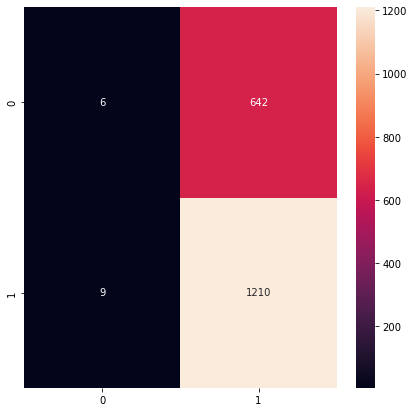

In [68]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction_re), annot=True, fmt='d', ax=ax)

<AxesSubplot:xlabel='labels', ylabel='count'>

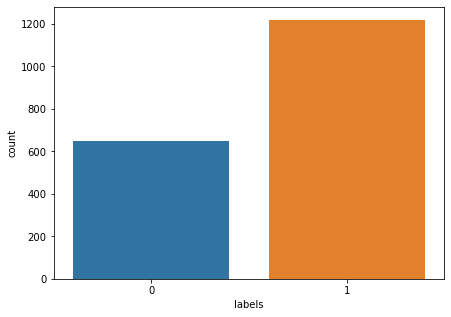

In [69]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
sns.countplot(x='labels', data=dataframe_testing)